In [1]:
!pip install langchain langchain-community faiss-cpu sentence-transformers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1

In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer
from sentence_transformers import SentenceTransformer
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline
import re
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


In [5]:
dataset = pd.read_csv("/content/sample_data/LaptrackPhase2.csv")
df = pd.DataFrame(dataset)
df.head()

,Brand,Laptop_Model_Name,Laptop_Model_Number,Processor_Brand,Processor_Model,Storage_Type,Operating_System,Display_Resolution,Extracted_Rating,Battery_Life(Hours_Upto),...,Stock,Time_Of_Extraction,URL,Source,Storage_Capacity(GB),Display_Size(Inches),RAM(GB),No_Of_Reviews,Laptop_Dimensions,Laptop_Weight(Pounds)
0,Dell,Latitude 3540 Laptop,NaN,Intel,1355U,SSD,Windows 11 Professional,1920x1080 MP,NaN,NaN,...,True,2024-11-04 18:23:39,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,Amazon,4000,15.6,64,0,0.71 x 14.13 x 9.44 inches,4.00
1,HP,17t-cn3004,17t-cn3004208,Intel,Intel Core i5,SSD,Windows 11 Pro,1600x900 Pixels,5.0,NaN,...,True,2024-11-04 18:23:42,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,Amazon,4096,17.3,64,0,0.81 x 10.15 x 15.78 inches,5.00
2,Dell,"Dell Inspiron 15.6"" Touchscreen Laptop",NaN,Intel,1355U,SSD,Windows 11 Pro,1920x1080 Pixels,NaN,NaN,...,True,2024-11-04 18:23:45,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,Amazon,4096,15.6,32,0,9.25 x 0.75 x 14.11 inches,3.60
3,Apple,MacBook Pro,Mvvm2ll/a,Intel,Core i9,SSD,Mac OS X 10.0 Cheetah,2560 x 1600 Pixels,4.0,11.0,...,True,2024-11-04 18:23:54,https://www.amazon.com/2019-Apple-MacBook-16-i...,Amazon,2048,16.0,16,0,15.63 x 2.40 x 11.14 inches,5.68
4,HP,TPN-Q279,TPN-Q279,AMD,Ryzen 5,SSD,Windows 11 Home,1920 x 1080 Pixels,3.8,NaN,...,True,2024-11-04 18:23:57,https://www.amazon.com/HP-i7-1355U-i5-14400F-G...,Amazon,2048,15.6,16,0,0.93 x 10.04 x 14.09 inches,7.39


In [6]:
print("Statistical description of the dataset")
df.describe()

Statistical description of the dataset


,Extracted_Rating,Battery_Life(Hours_Upto),Price,Storage_Capacity(GB),Display_Size(Inches),RAM(GB),No_Of_Reviews,Laptop_Weight(Pounds)
count,3490.000000,1145.000000,4196.000000,4196.000000,3836.000000,4196.000000,4196.000000,3825.000000
mean,4.236304,12.033013,842.118239,1074.086511,14.991715,19.806959,34.693994,4.770316
std,0.532802,25.875707,665.883846,1247.719175,1.339508,22.564708,470.825304,36.766237
min,1.000000,0.010000,44.990000,1.000000,4.000000,2.000000,0.000000,0.212000
25%,4.000000,8.000000,407.330000,512.000000,14.000000,8.000000,0.000000,3.200000
50%,4.300000,10.000000,642.495000,512.000000,15.600000,16.000000,0.000000,3.720000
75%,4.500000,13.000000,1089.990000,2048.000000,16.000000,24.000000,0.000000,4.600000
max,5.000000,850.000000,6099.990000,16384.000000,18.000000,512.000000,24919.000000,2268.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4196 entries, 0 to 4195
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Brand                     4196 non-null   object 
 1   Laptop_Model_Name         4167 non-null   object 
 2   Laptop_Model_Number       3796 non-null   object 
 3   Processor_Brand           4166 non-null   object 
 4   Processor_Model           4196 non-null   object 
 5   Storage_Type              4196 non-null   object 
 6   Operating_System          4190 non-null   object 
 7   Display_Resolution        4169 non-null   object 
 8   Extracted_Rating          3490 non-null   float64
 9   Battery_Life(Hours_Upto)  1145 non-null   float64
 10  Price                     4196 non-null   float64
 11  Stock                     4196 non-null   bool   
 12  Time_Of_Extraction        4196 non-null   object 
 13  URL                       4196 non-null   object 
 14  Source  

In [8]:
df.shape

(4196, 21)

In [9]:
df.isnull().sum()

,0
Brand,0
Laptop_Model_Name,29
Laptop_Model_Number,400
Processor_Brand,30
Processor_Model,0
Storage_Type,0
Operating_System,6
Display_Resolution,27
Extracted_Rating,706
Battery_Life(Hours_Upto),3051


In [10]:
df.drop(columns=['Laptop_Model_Number','URL','Time_Of_Extraction','Source'],inplace=True)

In [11]:
df.head()

,Brand,Laptop_Model_Name,Processor_Brand,Processor_Model,Storage_Type,Operating_System,Display_Resolution,Extracted_Rating,Battery_Life(Hours_Upto),Price,Stock,Storage_Capacity(GB),Display_Size(Inches),RAM(GB),No_Of_Reviews,Laptop_Dimensions,Laptop_Weight(Pounds)
0,Dell,Latitude 3540 Laptop,Intel,1355U,SSD,Windows 11 Professional,1920x1080 MP,NaN,NaN,1772.95,True,4000,15.6,64,0,0.71 x 14.13 x 9.44 inches,4.00
1,HP,17t-cn3004,Intel,Intel Core i5,SSD,Windows 11 Pro,1600x900 Pixels,5.0,NaN,788.00,True,4096,17.3,64,0,0.81 x 10.15 x 15.78 inches,5.00
2,Dell,"Dell Inspiron 15.6"" Touchscreen Laptop",Intel,1355U,SSD,Windows 11 Pro,1920x1080 Pixels,NaN,NaN,1099.99,True,4096,15.6,32,0,9.25 x 0.75 x 14.11 inches,3.60
3,Apple,MacBook Pro,Intel,Core i9,SSD,Mac OS X 10.0 Cheetah,2560 x 1600 Pixels,4.0,11.0,571.99,True,2048,16.0,16,0,15.63 x 2.40 x 11.14 inches,5.68
4,HP,TPN-Q279,AMD,Ryzen 5,SSD,Windows 11 Home,1920 x 1080 Pixels,3.8,NaN,755.98,True,2048,15.6,16,0,0.93 x 10.04 x 14.09 inches,7.39


In [12]:
df.shape

(4196, 17)

In [13]:
df.isnull().sum().sort_values(ascending=False)

,0
Battery_Life(Hours_Upto),3051
Extracted_Rating,706
Laptop_Dimensions,569
Laptop_Weight(Pounds),371
Display_Size(Inches),360
Processor_Brand,30
Laptop_Model_Name,29
Display_Resolution,27
Operating_System,6
Brand,0


### Fill missing values with mean(numerical features)



In [14]:
num_cols = ['Battery_Life(Hours_Upto)', 'Extracted_Rating', 'Laptop_Weight(Pounds)','Display_Size(Inches)',]
for col in num_cols:
    df[col].fillna(df[col].mean(), inplace=True)

### Fill missing values with mode(categorical Features)

In [15]:
# Fill categorical column
cat_cols = ['Brand', 'Operating_System','Laptop_Dimensions','Operating_System','Display_Resolution','Processor_Brand','Laptop_Model_Name']
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [16]:
df.isnull().sum().sort_values(ascending=False)

,0
Brand,0
Laptop_Model_Name,0
Processor_Brand,0
Processor_Model,0
Storage_Type,0
Operating_System,0
Display_Resolution,0
Extracted_Rating,0
Battery_Life(Hours_Upto),0
Price,0


In [17]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [18]:
#clean Column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace(r'[^\w]', '', regex=True)

In [19]:
df.head()

,Brand,Laptop_Model_Name,Processor_Brand,Processor_Model,Storage_Type,Operating_System,Display_Resolution,Extracted_Rating,Battery_LifeHours_Upto,Price,Stock,Storage_CapacityGB,Display_SizeInches,RAMGB,No_Of_Reviews,Laptop_Dimensions,Laptop_WeightPounds
0,Dell,Latitude 3540 Laptop,Intel,1355U,SSD,Windows 11 Professional,1920x1080 MP,4.236304,12.033013,1772.95,True,4000,15.6,64,0,0.71 x 14.13 x 9.44 inches,4.00
1,HP,17t-cn3004,Intel,Intel Core i5,SSD,Windows 11 Pro,1600x900 Pixels,5.000000,12.033013,788.00,True,4096,17.3,64,0,0.81 x 10.15 x 15.78 inches,5.00
2,Dell,"Dell Inspiron 15.6"" Touchscreen Laptop",Intel,1355U,SSD,Windows 11 Pro,1920x1080 Pixels,4.236304,12.033013,1099.99,True,4096,15.6,32,0,9.25 x 0.75 x 14.11 inches,3.60
3,Apple,MacBook Pro,Intel,Core i9,SSD,Mac OS X 10.0 Cheetah,2560 x 1600 Pixels,4.000000,11.000000,571.99,True,2048,16.0,16,0,15.63 x 2.40 x 11.14 inches,5.68
4,HP,TPN-Q279,AMD,Ryzen 5,SSD,Windows 11 Home,1920 x 1080 Pixels,3.800000,12.033013,755.98,True,2048,15.6,16,0,0.93 x 10.04 x 14.09 inches,7.39


### Advanced EDA and Useful Graphs

**Univariate Analysis**

Text(0.5, 1.0, 'Laptop Price Distribution')

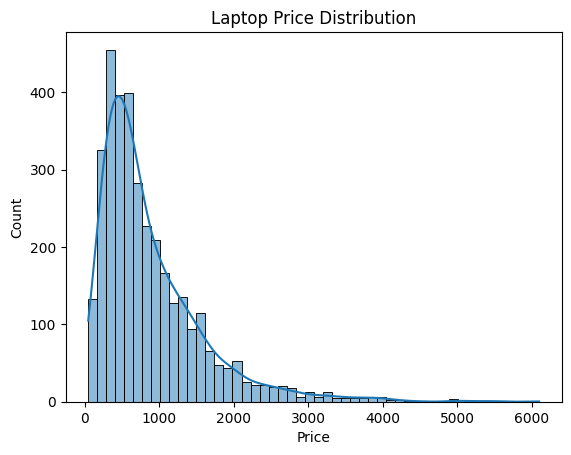

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Laptop Price Distribution")

Text(0.5, 1.0, 'Laptop Rating Distribution')

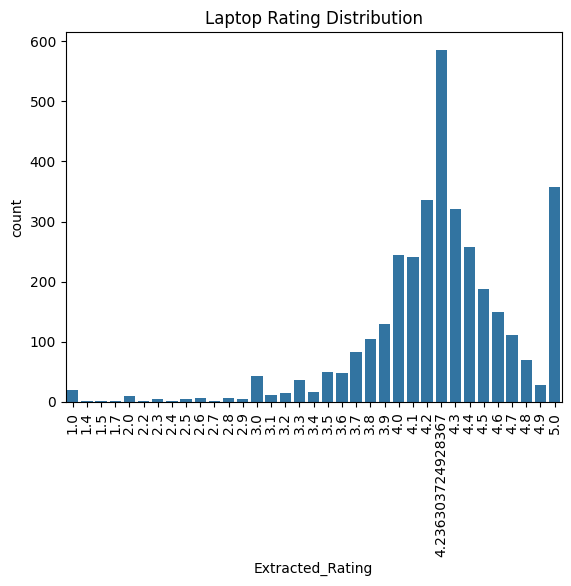

In [22]:
sns.countplot(x='Extracted_Rating', data=df)
plt.xticks(rotation=90)
plt.title("Laptop Rating Distribution")

<Axes: ylabel='count'>

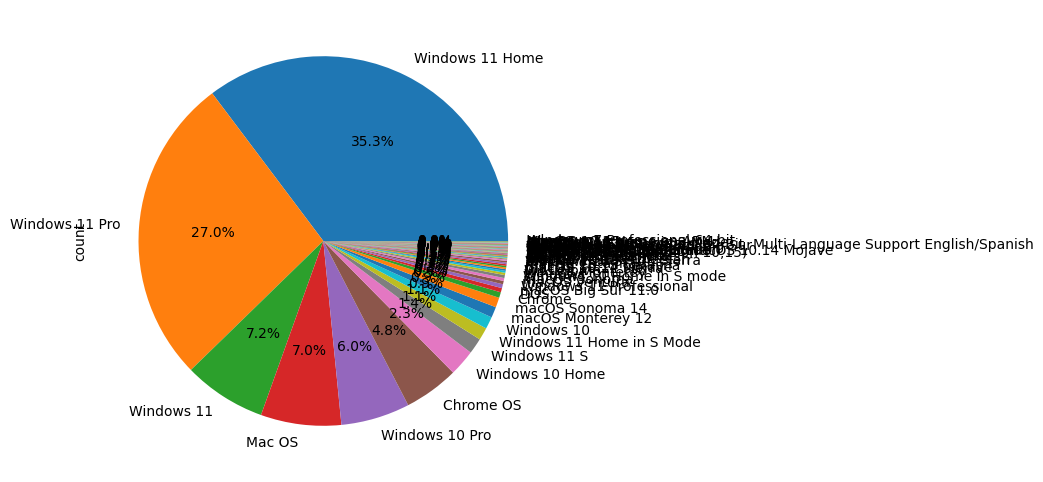

In [23]:
df['Operating_System'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6,6))

**Bivariate Analysis**

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96],
 [Text(0, 0, 'Dell'),
  Text(1, 0, 'HP'),
  Text(2, 0, 'Apple'),
  Text(3, 0, 'ist computers'),
  Text(4, 0, 'ASUS'),
  Text(5, 0, 'OTVOC'),
  Text(6, 0, 'Lenovo'),
  Text(7, 0, 'acer'),
  Text(8, 0, 'Z ZOLWAYTAC'),
  Text(9, 0, 'MSI'),
  Text(10, 0, 'jumper'),
  Text(11, 0, 'AOC'),
  Text(12, 0, 'NIMO'),
  Text(13, 0, 'FUNYET'),
  Text(14, 0, 'ACEMAGIC'),
  Text(15, 0, 'Morostron'),
  Text(16, 0, 'FURESTUR'),
  Text(17, 0,

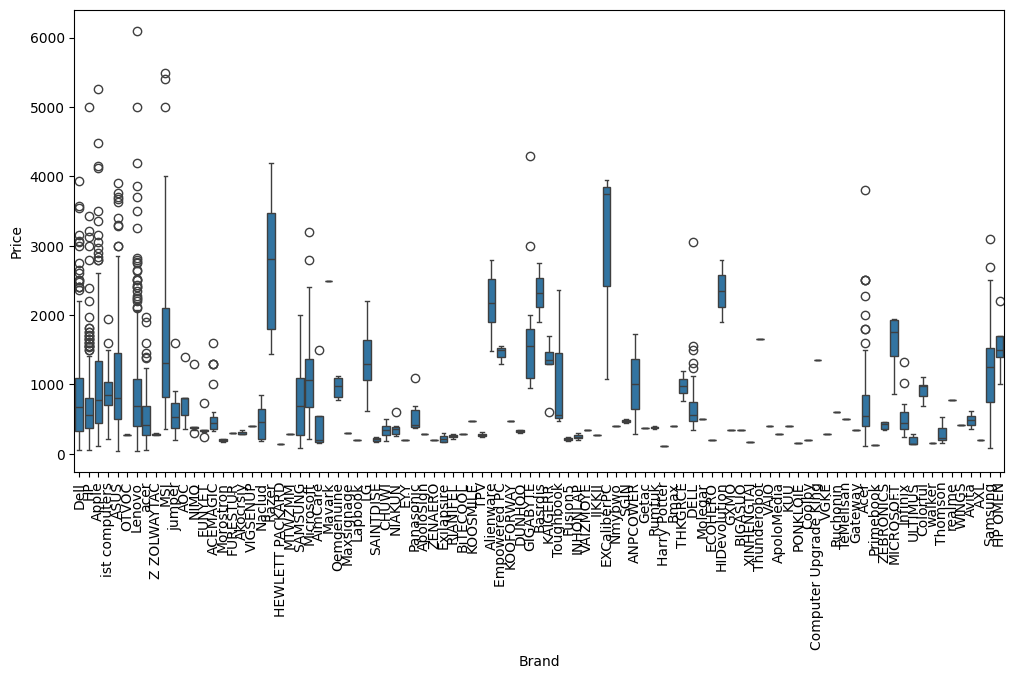

In [24]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Brand', y='Price', data=df)
plt.xticks(rotation=90)


<Axes: xlabel='RAMGB', ylabel='Price'>

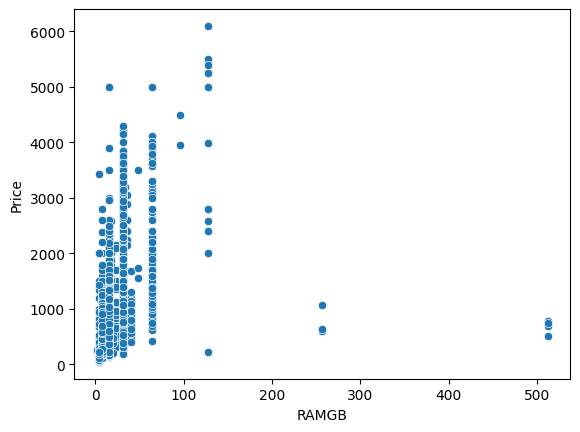

In [25]:
sns.scatterplot(x='RAMGB', y='Price', data=df)


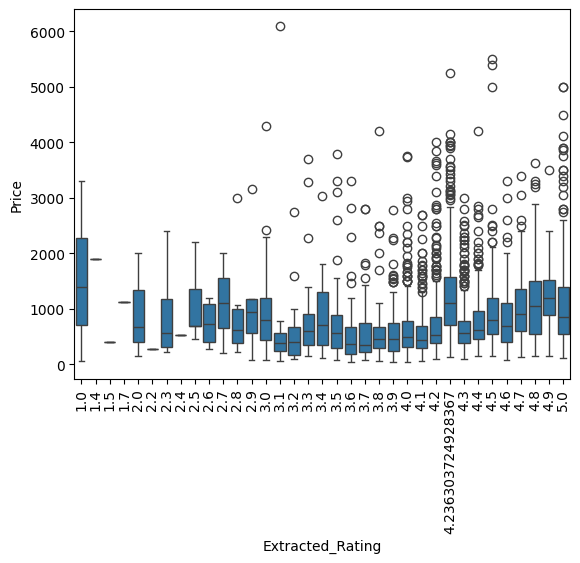

In [26]:
sns.boxplot(x='Extracted_Rating', y='Price', data=df)
plt.xticks(rotation=90)
plt.show()

**Multivariate Analysis**

<Axes: >

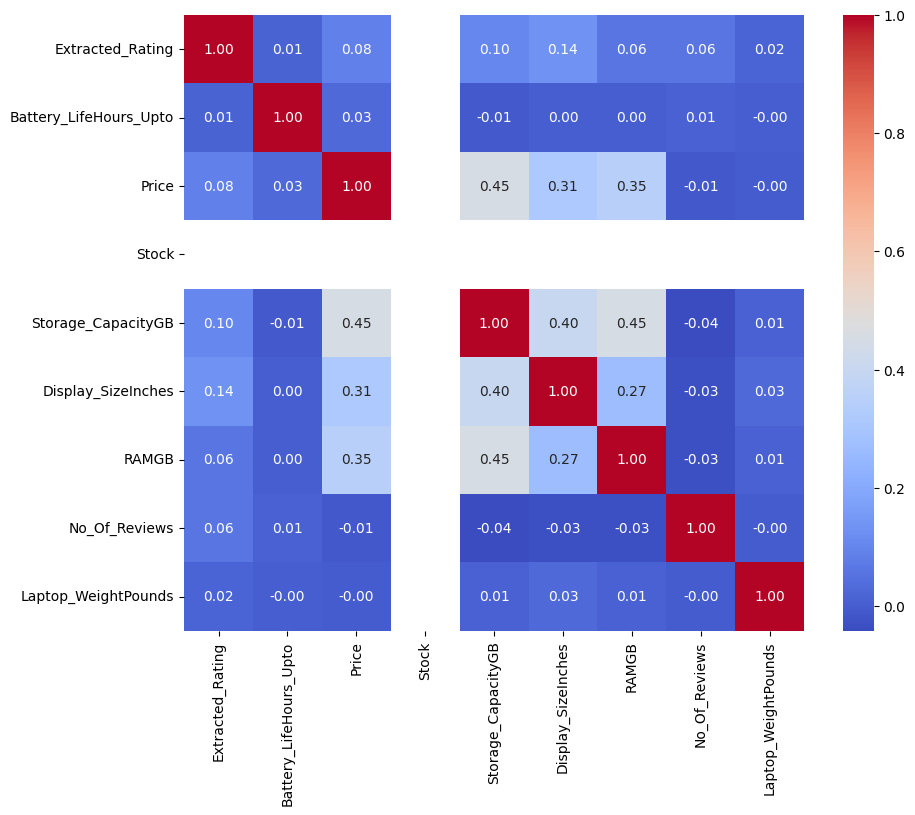

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')


<Axes: xlabel='count', ylabel='Processor_Brand'>

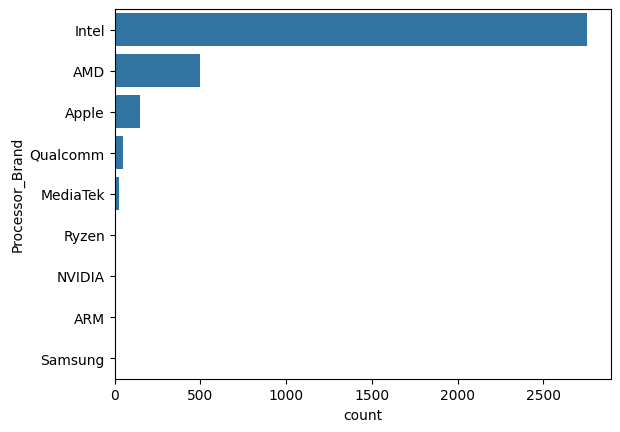

In [28]:
sns.countplot(y='Processor_Brand', data=df, order=df['Processor_Brand'].value_counts().index)


<Axes: ylabel='Operating_System'>

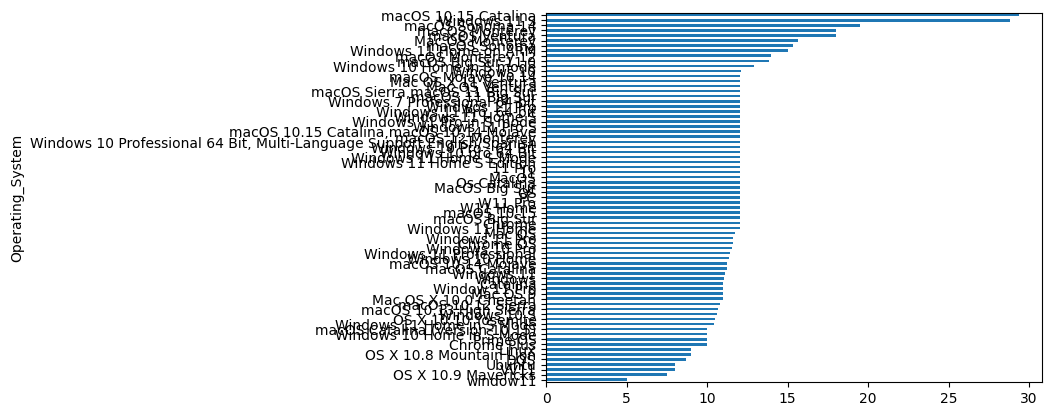

In [29]:
df.groupby('Operating_System')['Battery_LifeHours_Upto'].mean().sort_values().plot(kind='barh')


### Feature Engineering

In [30]:
from fractions import Fraction

def convert_to_float(val):
    try:
        if isinstance(val, str):
            val = val.strip()
            if ' ' in val:
                # Handle mixed number like '1 13/50'
                whole, frac = val.split()
                return float(int(whole) + Fraction(frac))
            elif '/' in val:
                return float(Fraction(val))
            else:
                return float(val)
        return float(val)
    except:
        return None  # Or np.nan if you prefer

# Step 1: Remove ' inches' and split
dims = df['Laptop_Dimensions'].str.replace(' inches', '', regex=False).str.split(' x ', expand=True)

# Step 2: Convert each part to float safely
df['Height_in'] = dims[0].apply(convert_to_float)
df['Width_in'] = dims[1].apply(convert_to_float)
df['Depth_in'] = dims[2].apply(convert_to_float)


In [31]:

# Convert pounds to kg (1 lb = 0.453592 kg)
df['Laptop_Weight_kg'] = df['Laptop_WeightPounds'] * 0.453592


In [32]:
# Basic SSD/HDD classification
df['Is_SSD'] = df['Storage_Type'].str.contains('SSD', case=False, na=False).astype(int)
df['Is_HDD'] = df['Storage_Type'].str.contains('HDD', case=False, na=False).astype(int)


In [33]:
def simplify_processor(model):
    model = str(model).lower()
    if 'i3' in model:
        return 'Intel i3'
    elif 'i5' in model:
        return 'Intel i5'
    elif 'i7' in model:
        return 'Intel i7'
    elif 'i9' in model:
        return 'Intel i9'
    elif 'ryzen 3' in model:
        return 'Ryzen 3'
    elif 'ryzen 5' in model:
        return 'Ryzen 5'
    elif 'ryzen 7' in model:
        return 'Ryzen 7'
    elif 'ryzen 9' in model:
        return 'Ryzen 9'
    else:
        return 'Other'

df['Processor_Category'] = df['Processor_Model'].apply(simplify_processor)


In [34]:
df.drop(columns=['Stock'], inplace=True)

In [35]:
df.head()

,Brand,Laptop_Model_Name,Processor_Brand,Processor_Model,Storage_Type,Operating_System,Display_Resolution,Extracted_Rating,Battery_LifeHours_Upto,Price,...,No_Of_Reviews,Laptop_Dimensions,Laptop_WeightPounds,Height_in,Width_in,Depth_in,Laptop_Weight_kg,Is_SSD,Is_HDD,Processor_Category
0,Dell,Latitude 3540 Laptop,Intel,1355U,SSD,Windows 11 Professional,1920x1080 MP,4.236304,12.033013,1772.95,...,0,0.71 x 14.13 x 9.44 inches,4.00,0.71,14.13,9.44,1.814368,1,0,Other
1,HP,17t-cn3004,Intel,Intel Core i5,SSD,Windows 11 Pro,1600x900 Pixels,5.000000,12.033013,788.00,...,0,0.81 x 10.15 x 15.78 inches,5.00,0.81,10.15,15.78,2.267960,1,0,Intel i5
2,Dell,"Dell Inspiron 15.6"" Touchscreen Laptop",Intel,1355U,SSD,Windows 11 Pro,1920x1080 Pixels,4.236304,12.033013,1099.99,...,0,9.25 x 0.75 x 14.11 inches,3.60,9.25,0.75,14.11,1.632931,1,0,Other
3,Apple,MacBook Pro,Intel,Core i9,SSD,Mac OS X 10.0 Cheetah,2560 x 1600 Pixels,4.000000,11.000000,571.99,...,0,15.63 x 2.40 x 11.14 inches,5.68,15.63,2.40,11.14,2.576403,1,0,Intel i9
4,HP,TPN-Q279,AMD,Ryzen 5,SSD,Windows 11 Home,1920 x 1080 Pixels,3.800000,12.033013,755.98,...,0,0.93 x 10.04 x 14.09 inches,7.39,0.93,10.04,14.09,3.352045,1,0,Ryzen 5


In [36]:
df.columns

Index(['Brand', 'Laptop_Model_Name', 'Processor_Brand', 'Processor_Model',
       'Storage_Type', 'Operating_System', 'Display_Resolution',
       'Extracted_Rating', 'Battery_LifeHours_Upto', 'Price',
       'Storage_CapacityGB', 'Display_SizeInches', 'RAMGB', 'No_Of_Reviews',
       'Laptop_Dimensions', 'Laptop_WeightPounds', 'Height_in', 'Width_in',
       'Depth_in', 'Laptop_Weight_kg', 'Is_SSD', 'Is_HDD',
       'Processor_Category'],
      dtype='object')

In [37]:
# Step 1: Keep a copy before dropping
df_original = df.copy()  # Before dropping text columns

### Preprocess and Index Data

In [38]:
# Combine relevant product information into a single text field for RAG
df['combined_text'] = df.apply(
    lambda row: (
        f"Brand: {row['Brand']} | Model: {row['Laptop_Model_Name']} | Processor: {row['Processor_Brand']} ({row['Processor_Category']}) | "
        f"Operating System: {row['Operating_System']} | Display: {row['Display_Resolution']} - {row['Display_SizeInches']} inches | "
        f"RAM: {row['RAMGB']} GB | Storage: {row['Storage_CapacityGB']} GB {'SSD' if row['Is_SSD'] else ''} {'HDD' if row['Is_HDD'] else ''} | "
        f"Battery Life: {row['Battery_LifeHours_Upto']} hrs | Rating: {row['Extracted_Rating']} stars | "
        f"Reviews: {row['No_Of_Reviews']} | Price: ${row['Price']} |"
        f"Dimensions: {row['Height_in']} x {row['Width_in']} x {row['Depth_in']} in | Weight: {row['Laptop_Weight_kg']} kg"
    ),
    axis=1
)

In [39]:
# Group every N rows into one "document"
from langchain.schema import Document

group_size = 5  # Number of rows per group
grouped_docs = []

for i in range(0, len(df), group_size):
    group_df = df.iloc[i:i + group_size]
    grouped_text = "\n\n".join(group_df["combined_text"].tolist())

    doc = Document(
        page_content=grouped_text,
        metadata={
            "group_index": i // group_size,
            "Laptop_Model_Name": group_df.iloc[0]["Laptop_Model_Name"],
            "Price": group_df.iloc[0]["Price"],
            "Extracted_Rating": group_df.iloc[0]["Extracted_Rating"]
        }
    )

    grouped_docs.append(doc)



In [40]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

split_documents = text_splitter.split_documents(grouped_docs)

In [41]:
# STEP 4: Create embedding model and vector store
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_documents(split_documents, embedding_model)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [42]:
print("Vector store created with", len(split_documents), "documents.")

Vector store created with 3482 documents.


### Set Up the LLM

In [43]:
# STEP 5: Load LLM
llm_pipeline = pipeline("text2text-generation", model="google/flan-t5-base", max_new_tokens=256,temperature=0.5)
llm = HuggingFacePipeline(pipeline=llm_pipeline)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0


In [44]:
# STEP 6: RAG chain (optional if you just use retrieval manually)
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vector_store.as_retriever(search_type="similarity", k=5),
    return_source_documents=True
)

### Query Understanding

In [45]:
# Step 8: Intent parsing and similarity functions
def parse_intent_and_attributes(query):
    try:
        query_lower = query.lower()

        # Define intent patterns
        intent_patterns = {
            "recommend": r"(recommend|suggest|find|best|budget|cheap|affordable|laptop for)",
            "compare": r"(compare|vs|versus|difference|better than)",
            "specification": r"(spec|specification|details|battery life|weight|ram|storage|processor|what is|how much)",
            "similar": r"(similar|like|close to|same as)",
            "general": r"(what|why|how|info|information|tell me)"
        }

        # Define attribute patterns
        attribute_patterns = {
            "price": r"under \$(\d+)|less than \$(\d+)",
            "rating": r"rating (?:above|at least|over )?(\d\.?\d*)",
            "battery": r"battery (?:life )?(?:over|at least|more than )?(\d+)",
            "weight": r"weight (?:under|less than|lighter than )?(\d\.?\d*)",
            "ram": r"(\d+) ?gb ram|\d+ ?gb memory",
            "storage": r"(\d+) ?gb storage|\d+ ?gb ssd",
            "brand": r"brand (?:is |like )?(\w+)",
            "os": r"(windows|mac|chrome|linux)"
        }
        # Rule-based intent detection
        intent = "general"
        for intent_name, pattern in intent_patterns.items():
            if re.search(pattern, query_lower):
                intent = intent_name
                break

        # Transformer-based fallback
        if intent == "general":
            try:
                intent_classifier = pipeline("text-classification", model="distilbert-base-uncased")
                result = intent_classifier(query_lower)
                if result[0]['label'] == "POSITIVE" and result[0]['score'] > 0.7:
                    intent = "recommend"
            except Exception as e:
                logger.error(f"Error in transformer-based intent detection: {e}")

        # Extract attributes
        attributes = {}
        for attr, pattern in attribute_patterns.items():
            match = re.search(pattern, query_lower)
            if match:
                attributes[attr] = match.group(1) if match.group(1) else match.group(0).split()[0]
        if "remote work" in query_lower or "work from home" in query_lower:
            attributes["use_case"] = "remote_work"
        if "student" in query_lower:
            attributes["use_case"] = "student"
        if "gaming" in query_lower:
            attributes["use_case"] = "gaming"

        logger.info(f"Parsed query '{query}' with intent '{intent}' and attributes {attributes}")
        return intent, attributes
    except Exception as e:
        logger.error(f"Error parsing intent and attributes: {e}")
        return "general", {}

def find_similar_laptops(df, vector_store, embedding_model, model_name=None, specs=None, top_k=3):
    try:
        if model_name:
            product_info = df[df['Laptop_Model_Name'].str.lower() == model_name.lower()]
            if product_info.empty:
                return []
            ref_vector = embedding_model.embed_query(product_info.iloc[0]['combined_text'])
        elif specs:
            query_str = f"laptop with {', '.join(f'{k}: {v}' for k, v in specs.items())}"
            ref_vector = embedding_model.embed_query(query_str)
        else:
            return []

        numerical_features = ['RAMGB', 'Storage_CapacityGB', 'Battery_LifeHours_Upto', 'Price', 'Laptop_Weight_kg']
        ref_numerical = product_info[numerical_features].iloc[0].values if model_name else np.array([specs.get(f, df[f].median()) for f in numerical_features])
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(df[numerical_features])

        text_similarities = []
        numerical_similarities = []
        for idx, row in df.iterrows():
            if model_name and row['Laptop_Model_Name'].lower() == model_name.lower():
                continue
            vector = embedding_model.embed_query(row['combined_text'])
            text_sim = cosine_similarity([ref_vector], [vector])[0][0]
            numerical_sim = cosine_similarity([ref_numerical], [scaled_features[idx]])[0][0]
            text_similarities.append(text_sim)
            numerical_similarities.append(numerical_sim)

        combined_similarities = 0.7 * np.array(text_similarities) + 0.3 * np.array(numerical_similarities)
        top_indices = np.argsort(combined_similarities)[::-1][:top_k]
        return [df.iloc[idx].to_dict() for idx in top_indices]
    except Exception as e:
        logger.error(f"Error in finding similar laptops: {e}")
        return []



In [46]:
# Step 9: Modified get_recommendation function
def get_recommendation(query, df, vector_store, embedding_model=embedding_model):
    try:
        # Parse intent and attributes
        intent, attributes = parse_intent_and_attributes(query)
        logger.info(f"Parsed query '{query}' with intent '{intent}' and attributes {attributes}")

        # Handle different intents
        if intent == "recommend":
            result = qa_chain({"query": query})
            retrieved_docs = result["source_documents"]
            generated_text = result["result"]

            # Default filters
            max_price = float(attributes.get("price", 999999)) if "price" in attributes else None
            min_rating = float(attributes.get("rating", 4)) if "rating" in attributes else 4
            min_battery = float(attributes.get("battery", 0)) if "battery" in attributes else 0
            max_weight = float(attributes.get("weight", float("inf"))) if "weight" in attributes else float("inf")
            min_ram = float(attributes.get("ram", 0)) if "ram" in attributes else 0
            min_storage = float(attributes.get("storage", 0)) if "storage" in attributes else 0
            brand = attributes.get("brand")
            os = attributes.get("os")
            use_case = attributes.get("use_case")

            recommended_products = []
            for doc in retrieved_docs:
                price = doc.metadata.get("Price", 999999)
                rating = doc.metadata.get("Extracted_Rating", 0)
                model_name = doc.metadata.get("Laptop_Model_Name", "Unknown")

                product_info = df[df['Laptop_Model_Name'] == model_name]
                if not product_info.empty:
                    product = product_info.iloc[0]
                    if (
                        (max_price is None or product['Price'] <= max_price) and
                        product['Extracted_Rating'] >= min_rating and
                        product['Battery_LifeHours_Upto'] >= min_battery and
                        product['Laptop_Weight_kg'] <= max_weight and
                        product['RAMGB'] >= min_ram and
                        product['Storage_CapacityGB'] >= min_storage and
                        (brand is None or brand.lower() in product['Brand'].lower()) and
                        (os is None or os.lower() in product['Operating_System'].lower()) and
                        (use_case != "remote_work" or (product['Battery_LifeHours_Upto'] >= 8 and product['Laptop_Weight_kg'] <= 1.6)) and
                        (use_case != "gaming" or product['performance_score'] >= df['performance_score'].quantile(0.75)) and
                        (use_case != "student" or product['Price'] <= 700)
                    ):
                        recommended_products.append({
                            "product_name": model_name,
                            "detailed_text": product["combined_text"]
                        })

            if recommended_products:
                response = f"Here are my recommendations for '{query}':\n"
                for i, rec in enumerate(recommended_products[:3], 1):
                    response += f"{i}. {rec['detailed_text']}\n"
                response += f"\nAdditional Info: {generated_text}"
            else:
                response = "Sorry, no products match your criteria.\nTry adjusting your query for better results."

        elif intent == "compare":
            product_names = re.findall(r"(?:compare|vs|versus)\s+([\w\s]+?)(?:\s+and\s+|\s+vs\s+)([\w\s]+)", query, re.IGNORECASE)
            if product_names:
                products = []
                for name, _ in product_names:
                    product_info = df[df['Laptop_Model_Name'].str.lower().str.contains(name.lower())]
                    if not product_info.empty:
                        products.append(product_info.iloc[0].to_dict())
                if len(products) >= 2:
                    response = "Comparison:\n"
                    for i, product in enumerate(products[:2], 1):
                        response += f"{i}. {product['combined_text']}\n"
                else:
                    response = "Not enough products found to compare."
            else:
                response = "Please specify two laptop models to compare."

        elif intent == "specification":
            model_name = re.search(r"(?:spec|details|what is)\s+([\w\s]+)", query, re.IGNORECASE)
            if model_name:
                product_info = df[df['Laptop_Model_Name'].str.lower().str.contains(model_name.group(1).lower())]
                response = product_info.iloc[0]['combined_text'] if not product_info.empty else "Laptop not found."
            else:
                response = "Please specify a laptop model for specifications."

        elif intent == "similar":
            model_name = re.search(r"(?:similar|like|close to)\s+([\w\s]+)", query, re.IGNORECASE)
            if model_name:
                products = find_similar_laptops(df, vector_store, embedding_model, model_name=model_name.group(1))
                if products:
                    response = f"Here are laptops similar to '{model_name.group(1)}':\n"
                    for i, product in enumerate(products, 1):
                        response += f"{i}. {product['combined_text']}\n"
                else:
                    response = f"No laptops found similar to '{model_name.group(1)}'."
            else:
                specs = {k: float(v) for k, v in attributes.items() if k in ['ram', 'storage', 'battery', 'weight', 'price']}
                if specs:
                    products = find_similar_laptops(df, vector_store, embedding_model, specs=specs)
                    response = "Here are laptops matching your specifications:\n"
                    for i, product in enumerate(products, 1):
                        response += f"{i}. {product['combined_text']}\n"
                else:
                    response = "Please specify a laptop model or specifications."

        else:
            result = qa_chain({"query": query})
            response = result["result"]

        return response
    except Exception as e:
        logger.error(f"Error processing query: {e}")
        return "Sorry, something went wrong. Please try again."

In [47]:
# Step 10: Interactive UI
def create_ui():
    query_input = widgets.Text(
        value="suggest me a laptop under $550",
        placeholder="Enter your query",
        description="Query:",
        layout={'width': '80%'}
    )
    output = widgets.Output()
    button = widgets.Button(description="Get Recommendation")

    def on_button_clicked(b):
        with output:
            output.clear_output()
            response = get_recommendation(query_input.value, df, vector_store)
            display(HTML(f"<pre>{response}</pre>"))

    button.on_click(on_button_clicked)
    display(widgets.VBox([query_input, button, output]))

In [48]:
 #Step 11: Evaluation
def evaluate_recommender():
    test_queries = [
        {"query": "suggest me a laptop under $550", "expected_intent": "recommend"},
        {"query": "compare Dell Inspiron and HP Envy", "expected_intent": "compare"},
        {"query": "what is the battery life of OTVOC VocBook 15 Pro", "expected_intent": "specification"},
        {"query": "find laptops similar to Lenovo IdeaPad 1 15IJL7", "expected_intent": "similar"},
        {"query": "what is a good laptop for gaming", "expected_intent": "recommend"}
    ]
    correct = 0
    for test in test_queries:
        intent, _ = parse_intent_and_attributes(test['query'])
        if intent == test['expected_intent']:
            correct += 1
    accuracy = correct / len(test_queries)
    logger.info(f"Intent recognition accuracy: {accuracy:.2f}")
    return accuracy

# Main execution
if __name__ == "__main__":
    # Create UI
    create_ui()

    # Evaluate
    accuracy = evaluate_recommender()
    print(f"Intent recognition accuracy: {accuracy:.2f}")

    # # Test the chatbot
    # query = "suggest me a laptop under $550"
    # response = get_recommendation(query, df, vector_store)
    # print(response)

Intent recognition accuracy: 0.80


In [49]:
# import pickle

# with open("vector_store.pkl", "wb") as f:
#     pickle.dump(vector_store, f)


In [ ]:
# from google.colab import files
# # df.to_csv("products.csv",index=False)
# # # Download CSV file
# # files.download("products.csv")

# # Download vector store (FAISS index or Pickle)
# files.download("vector_store.pkl")
